<a href="https://colab.research.google.com/github/ivoytov/manhattan/blob/master/NYC_price_index_on_voytov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Housing Price Index for NYC from Transaction Data

## Setup and Prepare the dataframe

In this section we import the data and clean it up. If you trust that we've one everything correctly, feel free to skip to the next section, where we use the historical transaction data to construct the first housing price index.

In [1]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
from pandas.api.types import CategoricalDtype
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import sparse

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
sns.set_theme()
%pdb

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.3 MB/s eta 0:00:00
Automatic pdb calling has been turned ON


In [2]:
cols = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESideNTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE']
cols = [col.lower().replace(" ","_") for col in cols]

Download all real estate transaction data from [NYC.gov](https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page) for January 2003 to July 2020. Only closed transactions are included. Column names are the same in all files. 

In [7]:
# ex: https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2019/2019_manhattan.xlsx
# 2020 ex: https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2020/2020_manhattan.xlsx
url_prefix_2021 = 'https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales'
url_prefix_pre_2021 = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales'
'https://www.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2021/2021_manhattan.xlsx'
years = range(2010,2022)
boroughs = ['manhattan', 'brooklyn', 'queens', 'bronx', 'statenisland']
df = pd.DataFrame()

def get_file(borough, year):
  url_prefix = url_prefix_2021 if year >= 2021 else url_prefix_pre_2021
  
  link =  f"{url_prefix}/annualized-sales/{year}/{year}_{borough if (year < 2020) | (borough != 'statenisland') else 'staten_island'}.xls{'x' if year > 2017 else ''}" 
  data = pd.read_excel(link, skiprows=(4 if year < 2020 else 7), names=cols, parse_dates=[20])
  print(f"{borough} {year} {data.sale_date.max()}")
  return data

def get_legacy_file(borough):
  links = [url_prefix_pre_2021 + f"/rollingsales_{borough}.xlsx", url_prefix_pre_2021 + f"/annualized-sales/2009_{borough}.xls",
          f"https://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_{borough}.xls", 
          f"https://www1.nyc.gov/assets/finance/downloads/excel/rolling_sales/sales_2007_{borough}.xls",
          *[f"https://www1.nyc.gov/assets/finance/downloads/sales_{borough if borough != 'statenisland' else 'si'}_0{n}.xls" for n in range(3,7)] ]

  return pd.concat([pd.read_excel(link, skiprows=4, names=cols, parse_dates=[20]) for link in links])

new_years = pd.concat([get_file(borough, year) for borough in boroughs for year in years])
old_years = pd.concat([get_legacy_file(borough) for borough in boroughs])
df = pd.concat([new_years, old_years])
    
df = df[['borough', 'neighborhood', 'building_class_category', 'block','lot', 'address', 'apartment_number', \
         'gross_square_feet', 'sale_price', 'year_built', 'sale_date']]
df.neighborhood = df.neighborhood.str.strip().str.title()
borough_type = CategoricalDtype(categories=['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island'], ordered=True)
df['borough'] = df.borough.map({1:"Manhattan", 2: "Bronx", 3: "Brooklyn", 4: "Queens", 5: "Staten Island"}).astype(borough_type)
df.head()

manhattan 2010 2010-04-22 00:00:00
manhattan 2011 2011-08-26 00:00:00
manhattan 2012 2012-07-09 00:00:00
manhattan 2013 2013-07-18 00:00:00
manhattan 2014 2014-12-05 00:00:00
manhattan 2015 2015-03-18 00:00:00
manhattan 2016 2016-12-22 00:00:00
manhattan 2017 2017-04-03 00:00:00
manhattan 2018 2018-05-23 00:00:00
manhattan 2019 2019-07-24 00:00:00
manhattan 2020 2020-10-02 00:00:00
manhattan 2021 2021-02-09 00:00:00
brooklyn 2010 2010-06-18 00:00:00
brooklyn 2011 2011-02-08 00:00:00
brooklyn 2012 2012-11-19 00:00:00
brooklyn 2013 2013-09-05 00:00:00
brooklyn 2014 2014-09-08 00:00:00
brooklyn 2015 2015-03-31 00:00:00
brooklyn 2016 2016-05-25 00:00:00
brooklyn 2017 2017-06-27 00:00:00
brooklyn 2018 2018-05-18 00:00:00
brooklyn 2019 2019-04-23 00:00:00
brooklyn 2020 2020-04-28 00:00:00
brooklyn 2021 2021-05-21 00:00:00
queens 2010 2010-01-21 00:00:00
queens 2011 2011-10-14 00:00:00
queens 2012 2012-10-05 00:00:00
queens 2013 2013-05-13 00:00:00
queens 2014 2014-01-09 00:00:00
queens 2015 

borough   neighborhood                       building_class_category  \
0  Manhattan  Alphabet City  01  ONE FAMILY HOMES                           
1  Manhattan  Alphabet City  02  TWO FAMILY HOMES                           
2  Manhattan  Alphabet City  03  THREE FAMILY HOMES                         
3  Manhattan  Alphabet City  03  THREE FAMILY HOMES                         
4  Manhattan  Alphabet City  04  TAX CLASS 1 CONDOS                         

   block   lot                                    address apartment_number  \
0    372    38  15 AVENUE D                                                  
1    376    32  91 AVENUE D                                                  
2    373    16  326 EAST 4TH STREET                                          
3    393     9  604 EAST 11TH   STREET                                       
4    399  1102  238 EAST 4TH   STREET                         -              

   gross_square_feet  sale_price  year_built  sale_date  
0             2240.0      593362      1910.0 2010-04-22  
1             3799.0     1320000      1901.0 2010-02-03  
2             3921.0      900000      1899.0 2010-12-15  
3             5110.0           0      1939.0 2010-06-25  
4                0.0     3027375      1955.0 2010-08-24


Exclude any transaction with sale price under \$100,000 as it might not be an arms length transaction or just bad data. The very last file we downloaded covers period of the last twelve months, so we need to remove duplicates in the overlapping period from the prior year.

Filter transactions to only include following categories:
* Coops
  * `09  coops - walkup apartments`
  * `10  coops - elevator apartments`
  * `17  condo coops`
* Condos
  * `12  condos - walkup apartments`
  * `13  condos - elevator apartments`

Clean up categories of homes - Single Family, Coops, Condos. Drop any sales < $100,000 (not true sales)

In [19]:
print("latest transaction in file:", df.sale_date.sort_values().iloc[-1])
df = df[(df.sale_price > 100000)].drop_duplicates()
SFH_CATEGORIES = "01"
COOP_CATEGORIES = "09|[^-]10|17" 
CONDO_CATEGORIES = "12|13"

sfh = df.building_class_category.str.contains(SFH_CATEGORIES)
coops = df.building_class_category.str.contains(COOP_CATEGORIES)
condos = df.building_class_category.str.contains(CONDO_CATEGORIES)

df['house_class'] = 'Condo'
df.loc[coops, 'house_class'] = 'Coop'
df.loc[sfh, 'house_class'] = 'SFH'

prop_type = CategoricalDtype(categories=['Condo', 'Coop', 'SFH', ], ordered=True)
df['house_class'] = df['house_class'].astype(prop_type)

df = df[coops | condos | sfh]

latest transaction in file: 2023-02-28 00:00:00


We need to create a unique ID to track unique houses. For condos, that is the block/lot number combination. But all Coops in the same building share the exact same lot number, so it's not a unique ID. We extract the apartment number from the ending of the address.

In [21]:
df.loc[condos | sfh, "uid"] = df[condos | sfh].block.map(str) + '_' + df[condos | sfh].lot.map(str)
df.loc[coops, "uid"] = (df[coops].block.map(str) + '_' + 
               df[coops].address.str.rsplit(',',n=1,expand=True)[1] 
                                .str.lower() 
                                .str.replace('(?:unit)?(?:apt)?[^a-z0-9\n]', '', regex=True))

We convert transaction periods to quarters (our index will be quarterly as a result). If the same house sold multiple times in the same quarter, remove the first transaction(s) and only keep the last transaction. This most likely represents a contractor flip.

<Axes: title={'center': 'Stacked Transactions by Type'}, xlabel='period'>

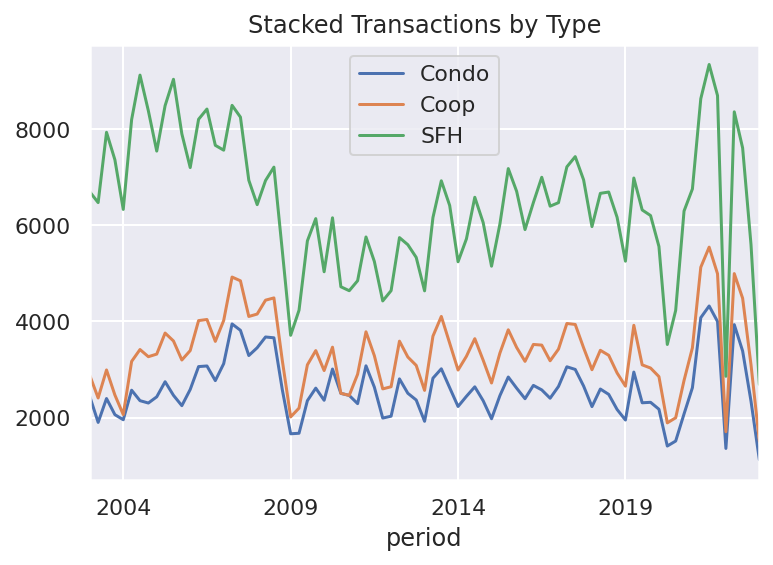

In [22]:
df['period'] = pd.PeriodIndex(df.sale_date, freq='Q')
df = df.drop_duplicates(subset=['period','uid'],keep='last')
df.groupby('period').house_class.value_counts().unstack().plot(kind='line', stacked=True,title="Stacked Transactions by Type")

In [23]:
df[(df.borough == "Manhattan") & (df.block==886) & (df.apartment_number=='1B')].sort_values('sale_date')

borough neighborhood          building_class_category  block   lot  \
9283  Manhattan  Murray Hill  13 CONDOS - ELEVATOR APARTMENTS    886  1202   
6844  Manhattan  Murray Hill  13 CONDOS - ELEVATOR APARTMENTS    886  1202   

                       address apartment_number  gross_square_feet  \
9283      127 EAST 30TH STREET               1B             1186.0   
6844  127 EAST 30TH STREET, 1B               1B                0.0   

      sale_price  year_built  sale_date house_class       uid  period  
9283     1050000         0.0 2018-09-06       Condo  886_1202  2018Q3  
6844      967338         NaN 2020-10-06       Condo  886_1202  2020Q4

Streaming output truncated to the last 5000 lines.


<Axes: >

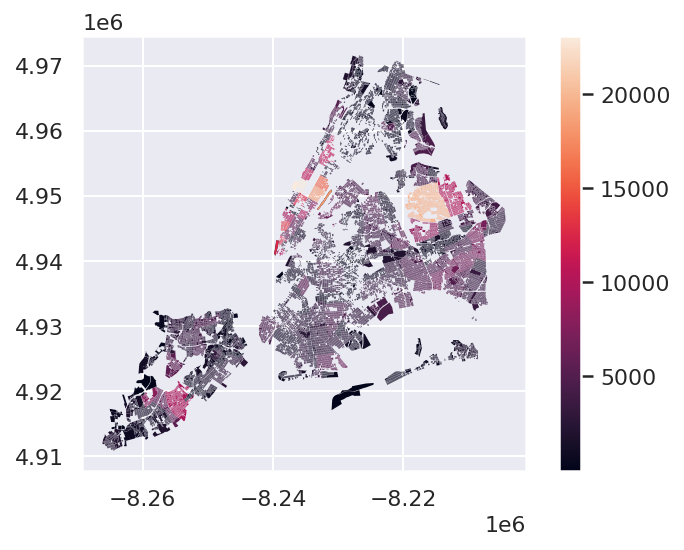

In [24]:
lotblock = gpd.read_file('https://drive.google.com/uc?export=download&id=1T12uhUyAwBdwZ4EKzAjXb3X1PiY3RBIp')
lotblock = lotblock[['BORO', 'BLOCK', 'SHAPE_AREA', 'geometry']].dropna()
lotblock.BORO = (
    lotblock.BORO.astype(int)
    .map({1:"Manhattan", 2: "Bronx", 3: "Brooklyn", 4: "Queens", 5: "Staten Island"})
    .astype(borough_type)
)
lotblock.BLOCK = lotblock.BLOCK.astype(int)
lotblock.columns = ['borough', 'block', 'area', 'geometry']
lotblock = lotblock.set_index(['borough', 'block']).to_crs(epsg=3395)
lotblock = lotblock.join(df.set_index(['borough', 'block'])[['neighborhood', 'sale_price', 'sale_date']]).dropna()
hoods = lotblock.dissolve(by=['borough', 'neighborhood'], aggfunc='count').set_crs(epsg=3395)
hoods.plot(column='sale_price', linewidth=0, legend=True)

This loop iterates through every borough and combines neighborhoods into top 10 largest. It does this by taking the smallest neighborhood (by # of transactions) and merging it with geographically closest neighborhood (by centroid). Then it repeats until only 10 neighborhoods in each borough are left.

In [25]:
hood_dict = {}
for boro in hoods.index.levels[0]:
  print("Merging neighborhoods in", boro)
  # remove the smallest neighborhoods until either the smallest neighborhood has >n transactions
  # or the borough is down to 5 neighborhoods total
  while len(hoods.loc[boro].index) > 5 and hoods.loc[boro].sale_date.sort_values(ascending=True).iloc[0] < 5000:
    smallest = hoods.loc[boro].sale_date.sort_values(ascending=True).index[0]
    smallest_count = hoods.loc[boro].sale_date.sort_values(ascending=True).iloc[0]
    smallest_center = hoods.loc[boro].centroid.loc[smallest]
    nearest_hood = hoods.loc[boro].centroid.distance(smallest_center).sort_values().index[1]
    hood_dict[smallest] = nearest_hood
    for key, value in hood_dict.items():
      if value == smallest:
        hood_dict[key] = nearest_hood
    old_cnt = hoods.loc[(boro, nearest_hood), 'sale_date']
    poly = hoods.loc[boro].loc[[nearest_hood, smallest]].unary_union
    hoods.loc[(boro, nearest_hood), 'geometry'] = hoods.loc[(boro, nearest_hood), 'geometry'] =gpd.GeoDataFrame(geometry=[poly]).geometry.values
    hoods.loc[(boro, nearest_hood), 'sale_date'] += hoods.loc[(boro, smallest), 'sale_date']
    new_cnt = hoods.loc[(boro, nearest_hood), 'sale_date']
    hoods.drop(smallest, level='neighborhood', inplace=True)
    print("Merging", smallest, "with", nearest_hood, "; transaction count", smallest_count)

Merging neighborhoods in Bronx
Merging Bronx Park with Bedford Park/Norwood ; transaction count 1
Merging Co-Op City with Baychester ; transaction count 52
Merging Hunts Point with Morrisania/Longwood ; transaction count 94
Merging Belmont with Fordham ; transaction count 122
Merging City Island-Pelham Strip with Baychester ; transaction count 123
Merging Mount Hope/Mount Eden with Bathgate ; transaction count 184
Merging Melrose/Concourse with Morrisania/Longwood ; transaction count 202
Merging Crotona Park with East Tremont ; transaction count 253
Merging Fieldston with Riverdale ; transaction count 308
Merging Fordham with Bathgate ; transaction count 379
Merging Woodlawn with Wakefield ; transaction count 407
Merging Westchester with Schuylerville/Pelham Bay ; transaction count 451
Merging Pelham Parkway South with Pelham Parkway North ; transaction count 468
Merging Kingsbridge Hts/Univ Hts with Bathgate ; transaction count 491
Merging Pelham Gardens with Pelham Parkway North ; tr

<Axes: >

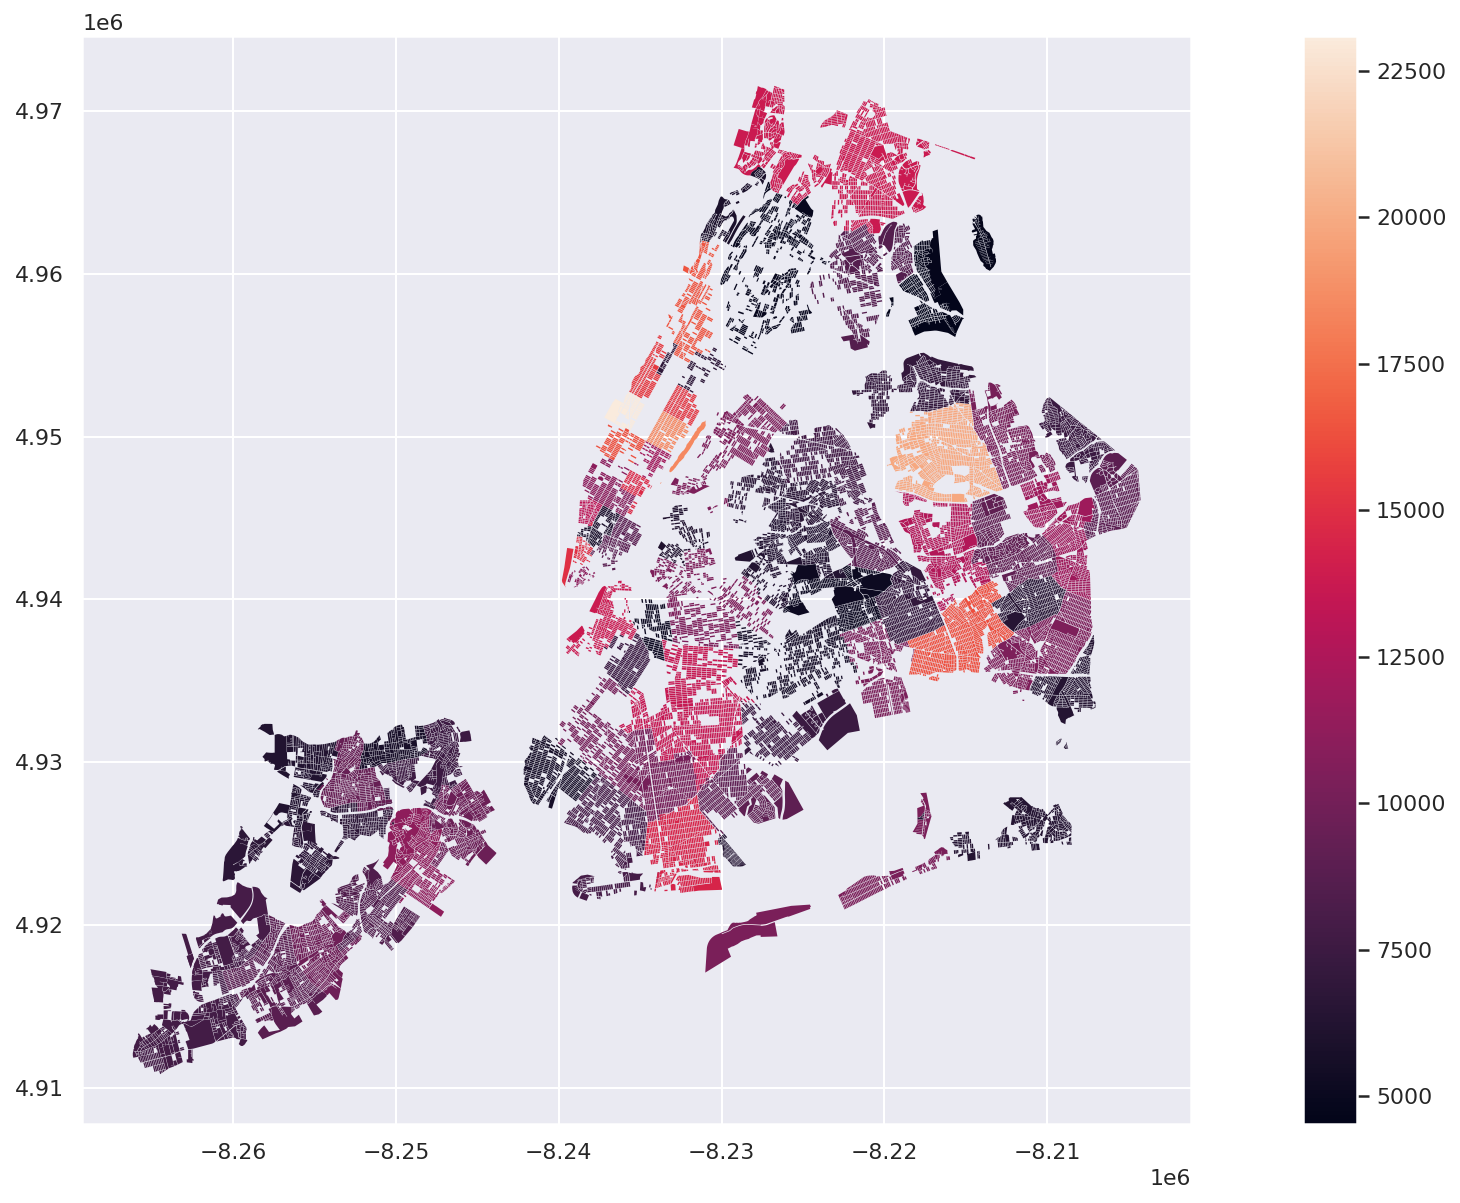

In [26]:
hoods.plot(column='sale_date', linewidth=0, legend=True, figsize=(20,10))

<Axes: >

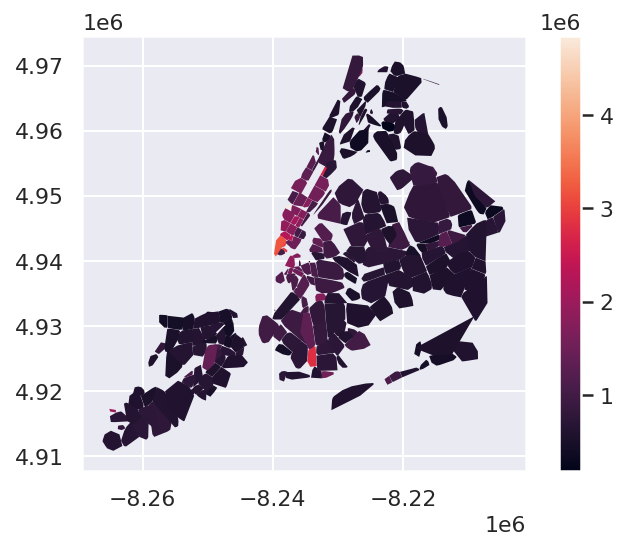

In [27]:
lotblock.replace({'neighborhood': hood_dict})
med_px = lotblock[lotblock.sale_date >= "2020-08-31"].dissolve(by=['borough', 'neighborhood'], aggfunc='median')
med_px.geometry = med_px.convex_hull
med_px.plot(column="sale_price", linewidth=0, legend=True)

<Axes: >

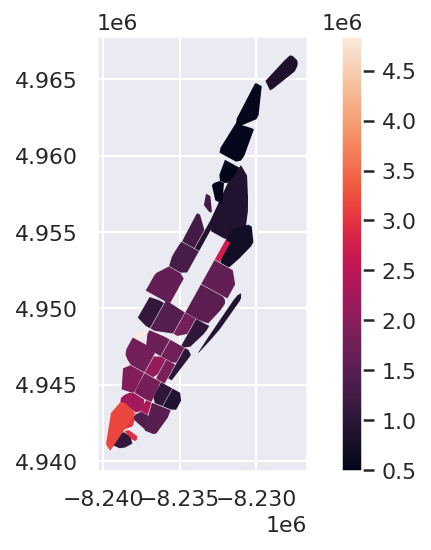

In [28]:
med_px.loc['Manhattan'].plot(column="sale_price", linewidth=0, legend=True)


In [29]:
df = df.replace({"neighborhood": hood_dict})
df.to_csv("nyc_real_estate_211231.csv")

In [30]:
qtr_offset = -1  # change this to -1 for latest quarter, -2 for the one before that and so on
mr_period = np.sort(df.period.unique())[qtr_offset]
print("Most recent period is", mr_period, "and # of transaction in this period:")
df[df.period == mr_period].house_class.value_counts()

Most recent period is 2023Q1 and # of transaction in this period:


SFH      1183
Condo    1121
Coop      384
Name: house_class, dtype: int64

In [44]:
''' Function takes in DataFrame rpt_sales with columns `uid`, `period`, and `sale_price`. 
    Returns:
        design matrices X, W, and Z as specified in the Case Shiller index methodology
        array deltaT:    number of periods elapsed between each sale pair
        array uid_key:   for each row of matrices, which house it represents
        array periods:   list of all unique periods, so columns can be converted to Periods 
'''
def createDesignMatrices(rpt_sales):
    grouped = rpt_sales.groupby('uid')
    S = np.sum(grouped.size()-1)
    periods = list(rpt_sales.period.unique())
    T = len(periods)

    # construct blank design matrices
    X = np.zeros((S, T))
    deltaT = np.zeros((S,1))
    
    uid_key = []
    row = 0
    for house, group in grouped:
      for i in range(len(group)-1):
        first = (group.iloc[i].sale_price, periods.index(group.iloc[i].period))
        second = (group.iloc[i+1].sale_price, periods.index(group.iloc[i+1].period))

        X[row,first[1]] = -first[0]
        X[row,second[1]] = second[0]
        deltaT[row] = second[1] - first[1]

        uid_key.append(house)
        row += 1

    W = np.reshape(-X[:,0],(-1,1))
    X = X[:,1:]
    Z = np.sign(X)

    return sparse.csr_matrix(X), W, sparse.csr_matrix(Z), deltaT, uid_key, periods

'''
    Constructs Case Shiller repeat sales index
    inputs: X,Z,W - design matrices as specified in the Case Shiller methodology. X and Z are sparse matrices
            periods - array of all periods in the sample
    outputs: DataFrame with index of periods and columns `weighted` and `unweighted` for the house price index
            first period index value is guaranteed to be 1.0 by convention
'''
def buildIndex(X, Z, W, deltaT, periods):
    #1) Estimate b by running regression using instrumental variables b = (Z'X)^-1 x X'w
    coeff = sparse.linalg.inv(Z.T * X) * Z.T * W
    #coeff = np.linalg.inv(Z.T.dot(X)).dot(Z.T).dot(W)
    idx = 1/(coeff.reshape(X.shape[1]))
    unweighted = pd.DataFrame([1,*idx], index=periods, columns=['unweighted'])

    #2) Calculate weights for each observation 
    resid = W - X.dot(coeff)
    reg = LinearRegression().fit(deltaT, resid**2)
    weights = np.sqrt(reg.predict(deltaT).clip(min=0.00001))
    Omega = sparse.diags(np.reshape(1/weights,X.shape[0]))

    #3) Estimate b again incorporating weights b = (Z'OmegaX)^-1 x Z'Omega w
    coeff_weighted = sparse.linalg.inv(Z.T * Omega * X) * Z.T * Omega * W
    idx_weighted = 1/(coeff_weighted.reshape(X.shape[1]))
    weighted = pd.DataFrame([1,*idx_weighted],index=periods, columns=['weighted'])

    return pd.concat([unweighted, weighted], axis=1), weights

'''
    Function generates unweighted, weighted, and smoothed (rolling) values for price index
    Takes in DataFrame and column key, an index will be returned for each unique value in df.key
'''
def generateIndexValues(df, key):
    grouped = df.groupby(key)
    results = None
    for name, group in grouped:
        X, W, Z, deltaT, uid_key, periods = createDesignMatrices(group)
        try:
            idx,weights = buildIndex(X,Z,W, deltaT, periods)
            idx[key] = name
            
            smoothed = idx.weighted.rolling(4,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).rename("smoothed")
            
            idx = pd.concat([idx,smoothed], axis=1)
            
            if results is None:
                results = idx
            else:
                results = pd.concat([results, idx])
            
        except Exception as e:
            print(name, e)
      
    return results

def plot_standings(data, title, figsize=(15,2.5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    bars = ax.bar(data.index, data, width=.825, capsize=2, color=[.7,.7,.7])

    ax.axhline(0.0, linestyle=':', color='k', lw=1)

    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1%}"))

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticklabels(data.index, rotation=90, fontsize=11)
    fig.set_facecolor('w')

''' Helper function to create a time series index plot. 
Result is a dataframe with cols weighted and smoothed'''
def plot_idx(result, ax, area_name, ylim=(0.5,3.0)):
    index = result.index.to_timestamp()
    ax.set_title(f"{area_name} House Price Index")

    ax.plot(index, result.weighted.values, 
                   c='k',
                   linestyle=':',
                   alpha=.5, label="Actual")

    ax.plot(index, result.smoothed.values, label="Smoothed")
    
    ax.axhline(1.0, c='k', lw=1, alpha=.25)
    ax.legend(frameon=False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    
    ax.set_ylim(ylim[0],ylim[1])
    ax.margins(0)

## Calculate the index values for NYC

Filter for only homes that have sold more than once (not technically required but reduces memory usage), sort by date

<Axes: title={'center': 'Repeat Transactions Only by Type'}, xlabel='period'>

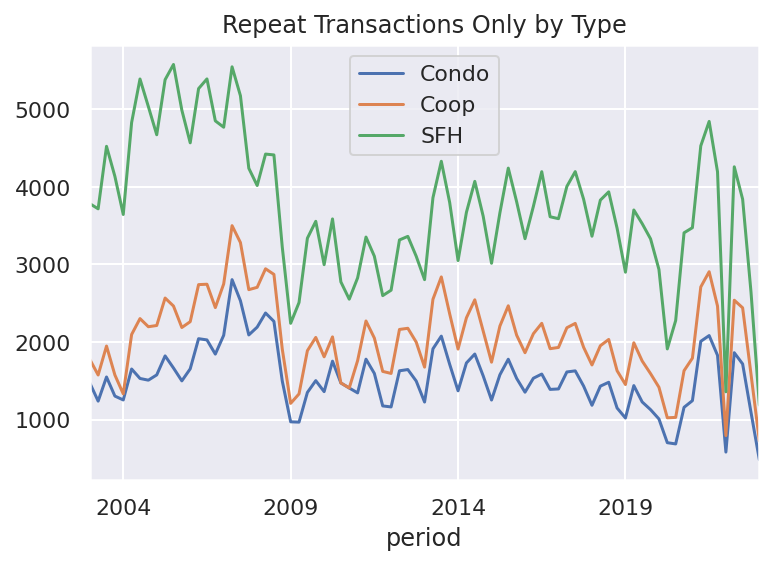

In [32]:
rpt_sales = df[['period', 'uid', 'sale_price', 'borough', 'neighborhood', 'sale_date', 'house_class']] \
                .groupby(['borough', 'uid']) \
                .filter(lambda x: len(x) >= 2) \
                .sort_values('sale_date')

rpt_sales.groupby('period').house_class.value_counts().unstack().plot(kind='line', stacked=True,title="Repeat Transactions Only by Type")

Number of repeat transactions in the most recent period

In [33]:
rpt_sales[rpt_sales.period == mr_period].house_class.value_counts()

Condo    481
SFH      460
Coop     245
Name: house_class, dtype: int64

Build design matrices, and construct the index values. Indices are constructed using the repeat sales methodology, meaning that we only look at homes that have sold several times and track the percentage change in price between the first sale and the next sale, which ideally represents an apples-to-apples comparison. See Case Shiller methodology for full description. Known issues is that if the house was remodeled or otherwise improved, we don't have this information so it wouldn't get incorporated. But homes also on average lose value to depreciation/age, and with thousands of transactions this represents the best price comparison possible.

In [34]:
X, W, Z, deltaT, uid_key, periods = createDesignMatrices(rpt_sales)


In [35]:
idx_all, weights = buildIndex(X, Z, W, deltaT, periods)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-31-e5eac79444fe>(48)buildIndex()
-> coeff = sparse.linalg.inv(Z.T * X) * Z.T * W
(Pdb) c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 345, in set_continue
    sys.settrace(None)



Plot the weighted house price index along with a 1-year/4-quarter rolling average.

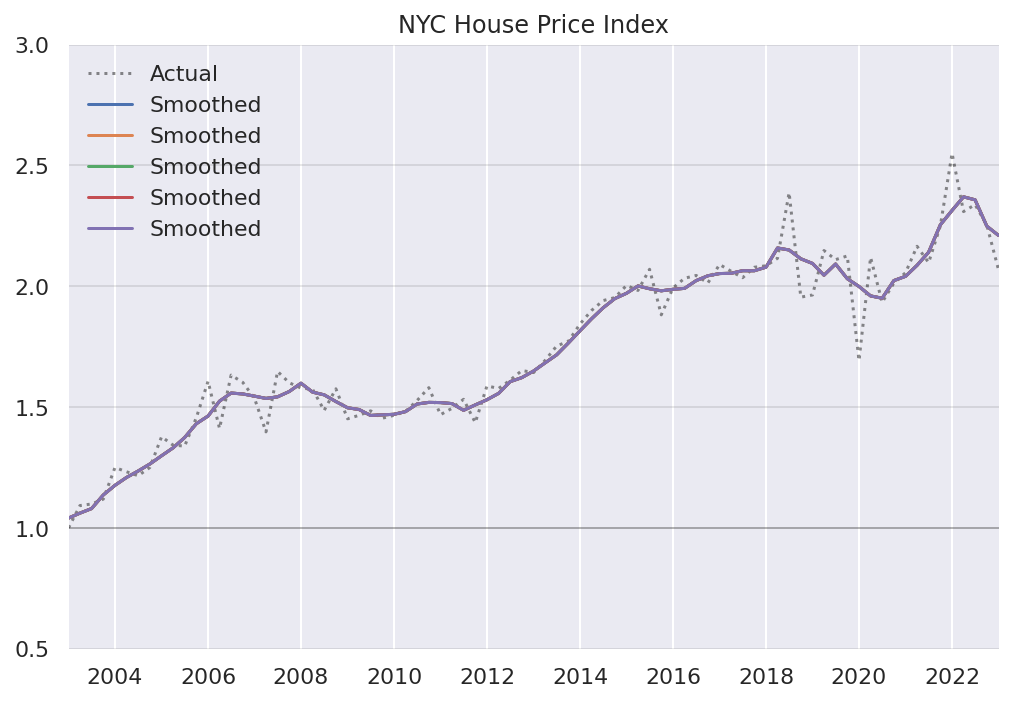

In [45]:
smoothed = idx_all.weighted.rolling(4,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).rename("smoothed")

fig, ax = plt.subplots(figsize=(600/72,400/72))
idx_all = pd.concat([idx_all, smoothed], axis=1)
plot_idx(idx_all, ax, "NYC")
fig.patch.set_alpha(1.0)

# Borough

Create a separate index for each borough, like Manhattan and Brooklyn

In [39]:
borough_idx = generateIndexValues(rpt_sales,'borough')

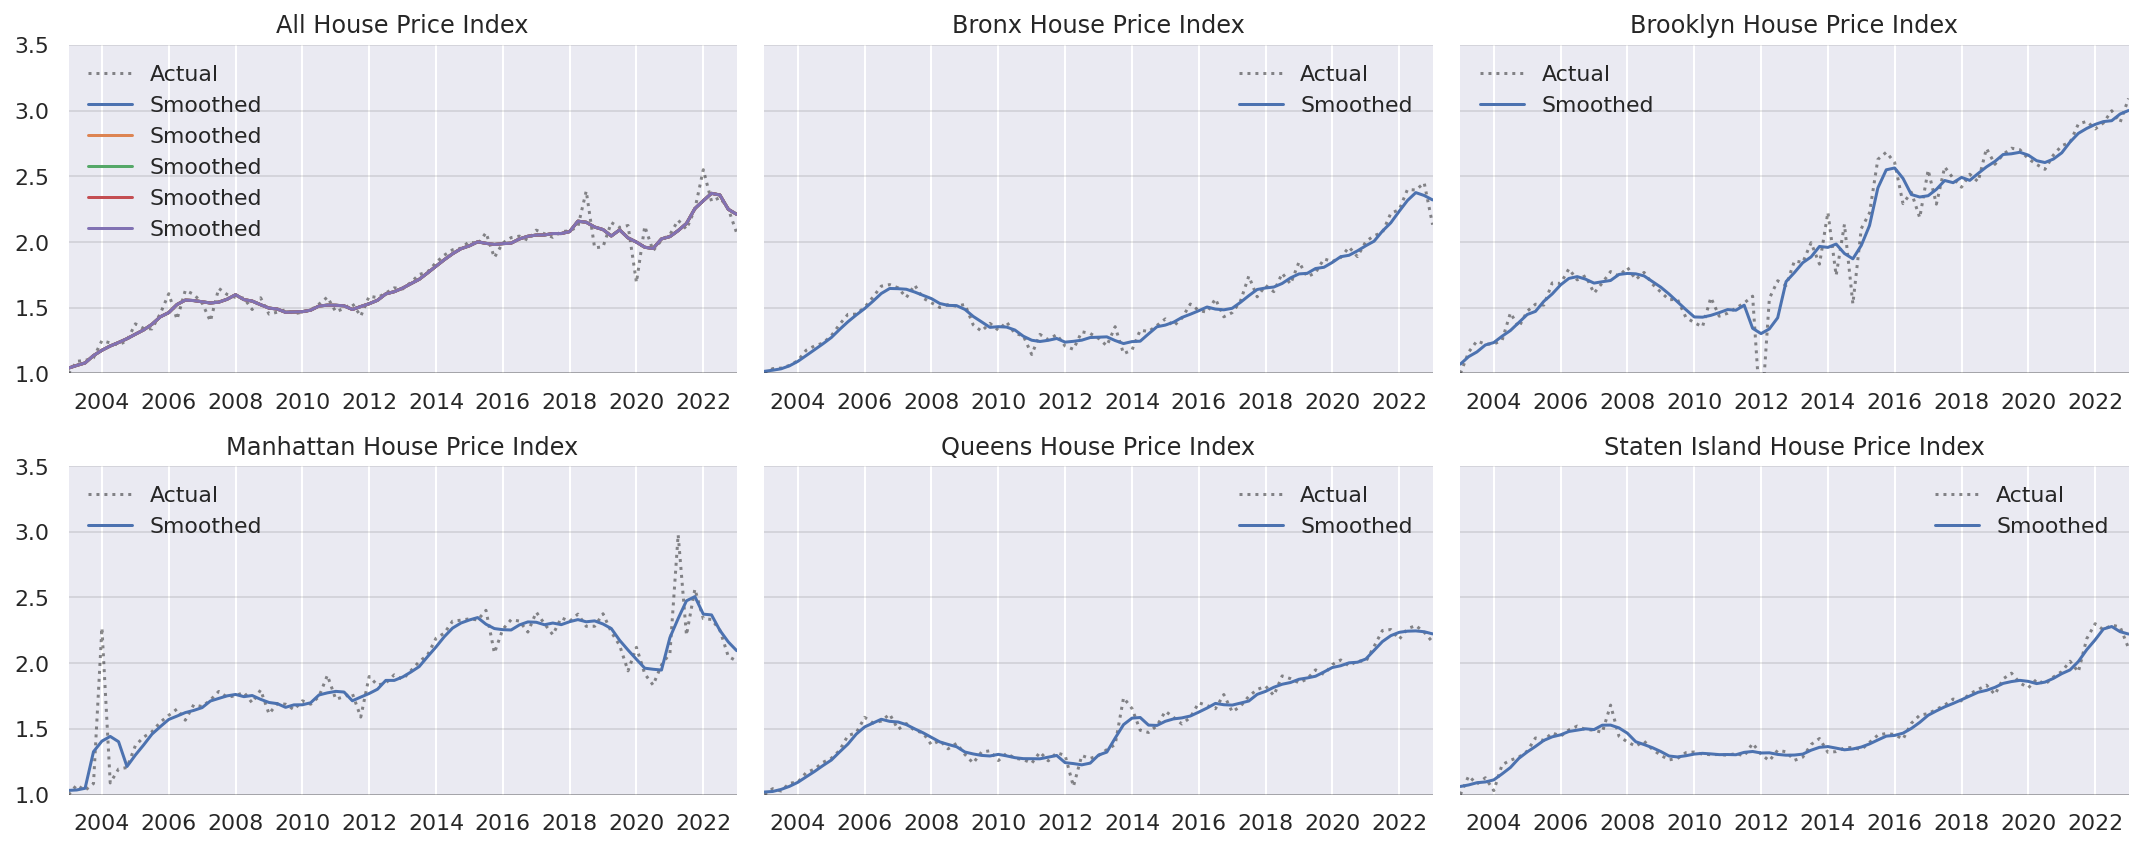

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), sharey=True)

plot_idx(idx_all, axes.flat[0], "All", ylim=(1,3.5))

for row, (name, idx) in enumerate(borough_idx.groupby('borough'),1):
    plot_idx(idx, axes.flat[row], name, ylim=(1,3.5))

fig.patch.set_alpha(1.0)             
fig.tight_layout()

<ipython-input-44-54d12e5df0e4>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=90, fontsize=11)


borough
Bronx              4%
Brooklyn           4%
Manhattan        -12%
Queens            -1%
Staten Island      2%
All               -4%
Name: 2023Q1, dtype: object

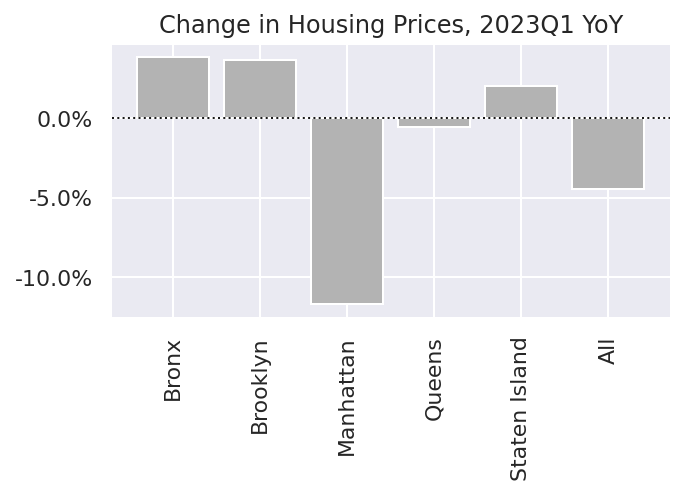

In [58]:
mr = borough_idx.set_index('borough',append=True).smoothed.unstack('borough').pct_change(4).iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change(4).iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} YoY", figsize=(5,2.5))
mr.map("{:.0%}".format)

<ipython-input-44-54d12e5df0e4>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=90, fontsize=11)


borough
Bronx              4%
Brooklyn           4%
Manhattan        -12%
Queens            -1%
Staten Island      2%
All               -2%
Name: 2023Q1, dtype: object

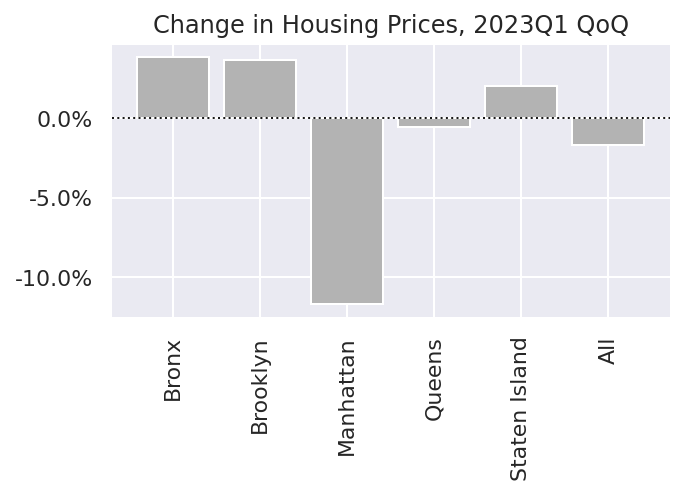

In [59]:
qmr = borough_idx.set_index('borough',append=True).smoothed.unstack('borough').pct_change().iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change().iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} QoQ", figsize=(5,2.5))
mr.map("{:,.0%}".format)

## Calculate index values for SFH, Condos, and Coops

We use the same methodology to generate separate indexes for Condos and Coops in Manhattan. As shown above, there are 4x more condo transactions than coop transactions in our dataset, so the condo index has higher statistical validity. 

In [60]:
house_class_idx = generateIndexValues(rpt_sales,'house_class')

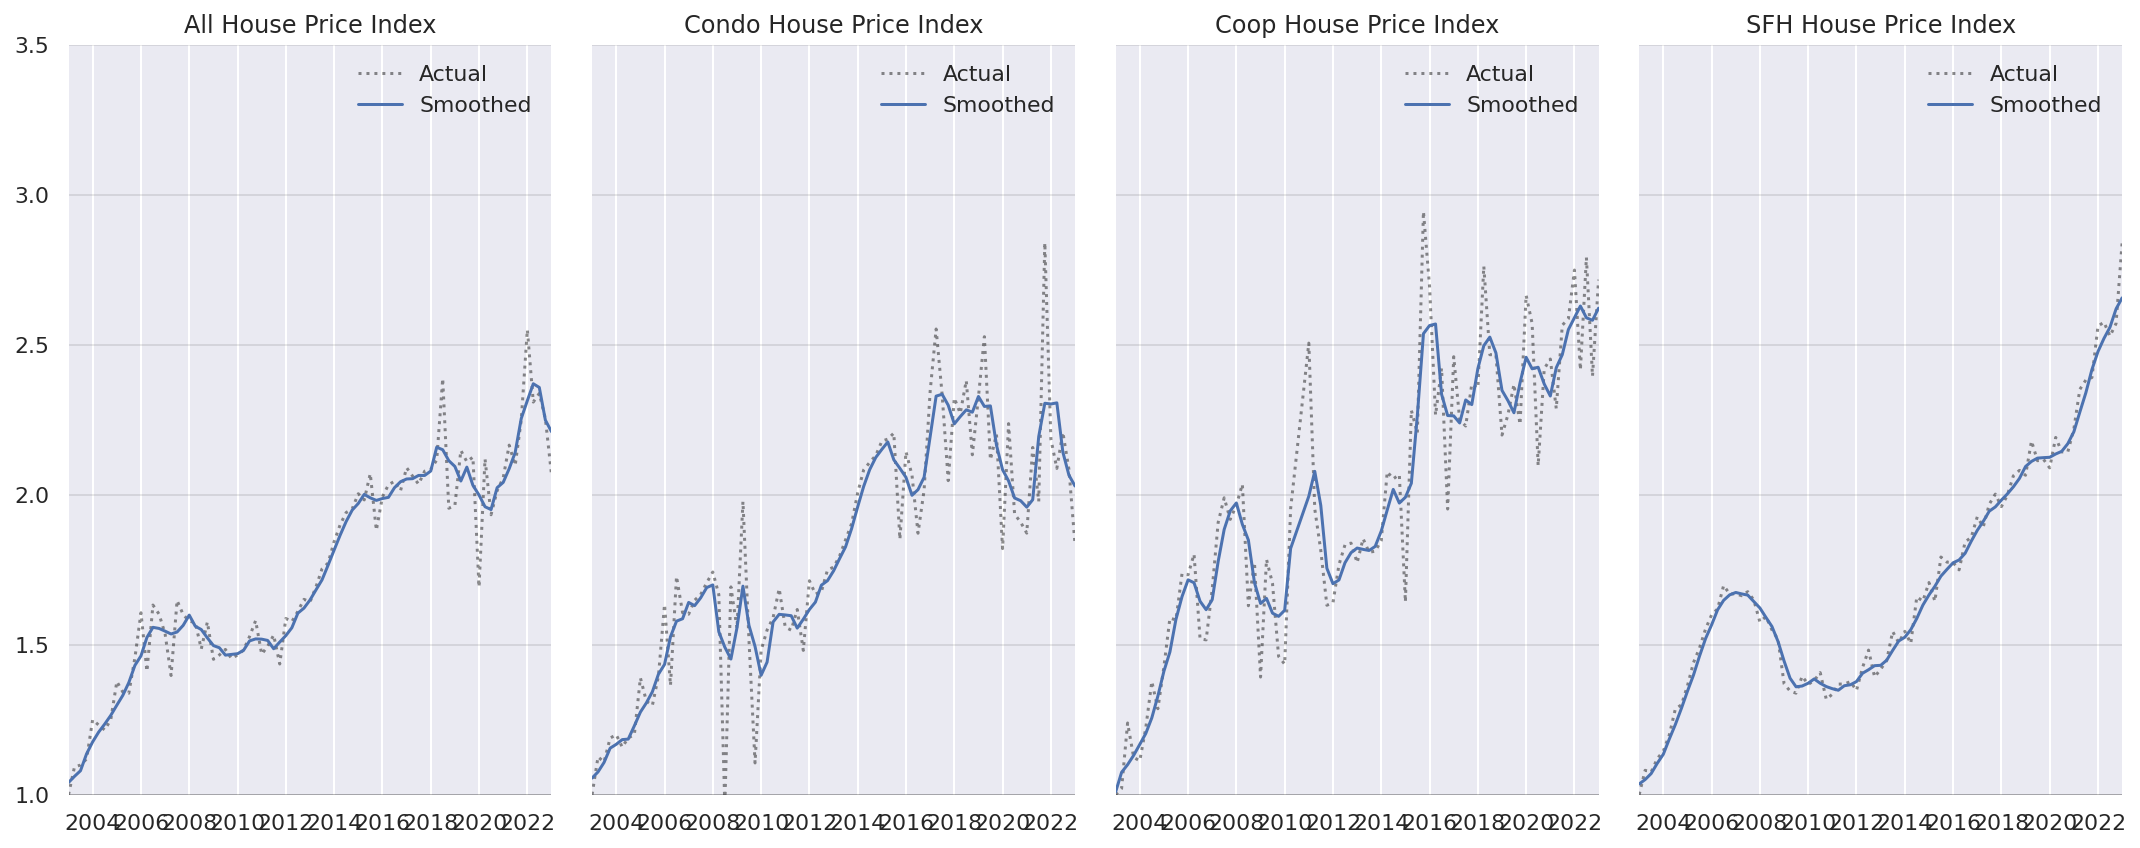

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6), sharey=True)

plot_idx(idx_all, axes.flat[0], "All", ylim=(1,3.5))

for row, (name, idx) in enumerate(house_class_idx.groupby('house_class'),1):
    plot_idx(idx, axes.flat[row], name, ylim=(1,3.5))

fig.patch.set_alpha(1.0)             
fig.tight_layout()

Show the year over year change in prices:

<ipython-input-44-54d12e5df0e4>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=90, fontsize=11)


house_class
Condo    -12%
Coop       1%
SFH        7%
All       -4%
Name: 2023Q1, dtype: object

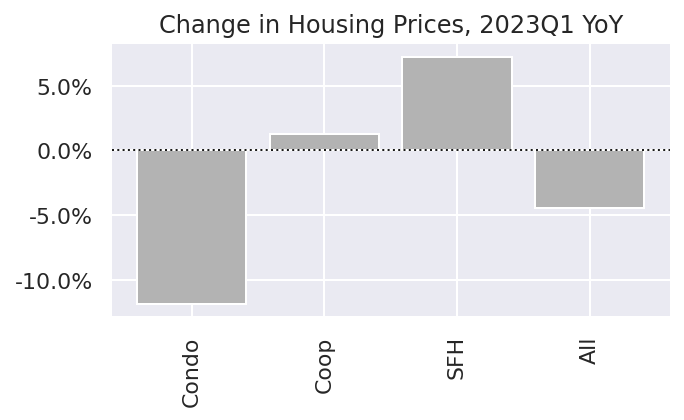

In [62]:
mr = house_class_idx.set_index('house_class',append=True).smoothed.unstack('house_class').pct_change(4).iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change(4).iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} YoY", figsize=(5,2.5))
mr.map("{:,.0%}".format)

Show the Quarter over Quarter change:

<ipython-input-44-54d12e5df0e4>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=90, fontsize=11)


house_class
Condo    -2%
Coop      2%
SFH       1%
All      -2%
Name: 2023Q1, dtype: object

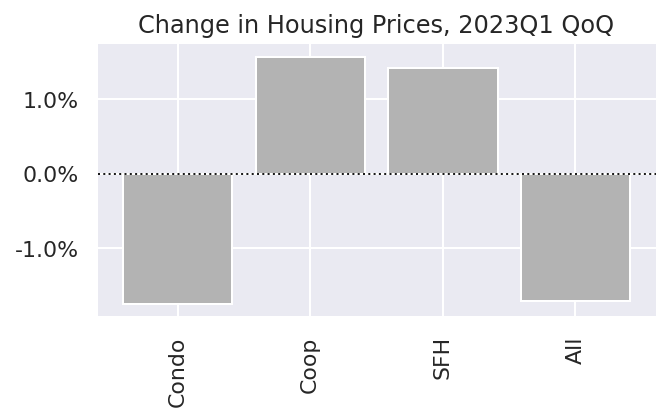

In [63]:
mr = house_class_idx.set_index('house_class',append=True).smoothed.unstack('house_class').pct_change().iloc[qtr_offset]
mr.loc['All'] = idx_all.smoothed.pct_change().iloc[qtr_offset:].values[0]
plot_standings(mr, title=f"Change in Housing Prices, {idx_all.index[qtr_offset]} QoQ", figsize=(5,2.5))
mr.map("{:,.0%}".format)

## Calculate index values for each neighborhood

Eliminate a few neighborhoods with errant transactions and then apply our prepared mapping of neighborhoods into larger districts with sufficient quantity of transactions.


In [67]:
hood_dict

{'Bronx Park': 'Pelham Parkway North',
 'Co-Op City': 'Pelham Parkway North',
 'Hunts Point': 'Bathgate',
 'Belmont': 'Bathgate',
 'City Island-Pelham Strip': 'Pelham Parkway North',
 'Mount Hope/Mount Eden': 'Bathgate',
 'Melrose/Concourse': 'Bathgate',
 'Crotona Park': 'Bathgate',
 'Fieldston': 'Pelham Parkway North',
 'Fordham': 'Bathgate',
 'Woodlawn': 'Pelham Parkway North',
 'Westchester': 'Parkchester',
 'Pelham Parkway South': 'Pelham Parkway North',
 'Kingsbridge Hts/Univ Hts': 'Bathgate',
 'Pelham Gardens': 'Pelham Parkway North',
 'Castle Hill/Unionport': 'Parkchester',
 'Highbridge/Morris Heights': 'Bathgate',
 'Mott Haven/Port Morris': 'Bathgate',
 'East Tremont': 'Bathgate',
 'Morris Park/Van Nest': 'Parkchester',
 'Bedford Park/Norwood': 'Pelham Parkway North',
 'City Island': 'Country Club',
 'Williamsbridge': 'Pelham Parkway North',
 'Schuylerville/Pelham Bay': 'Parkchester',
 'Soundview': 'Parkchester',
 'Bronxdale': 'Pelham Parkway North',
 'Kingsbridge/Jerome Park':

<Axes: title={'center': 'Number of repeat sales in dataset'}, xlabel='neighborhood,borough'>

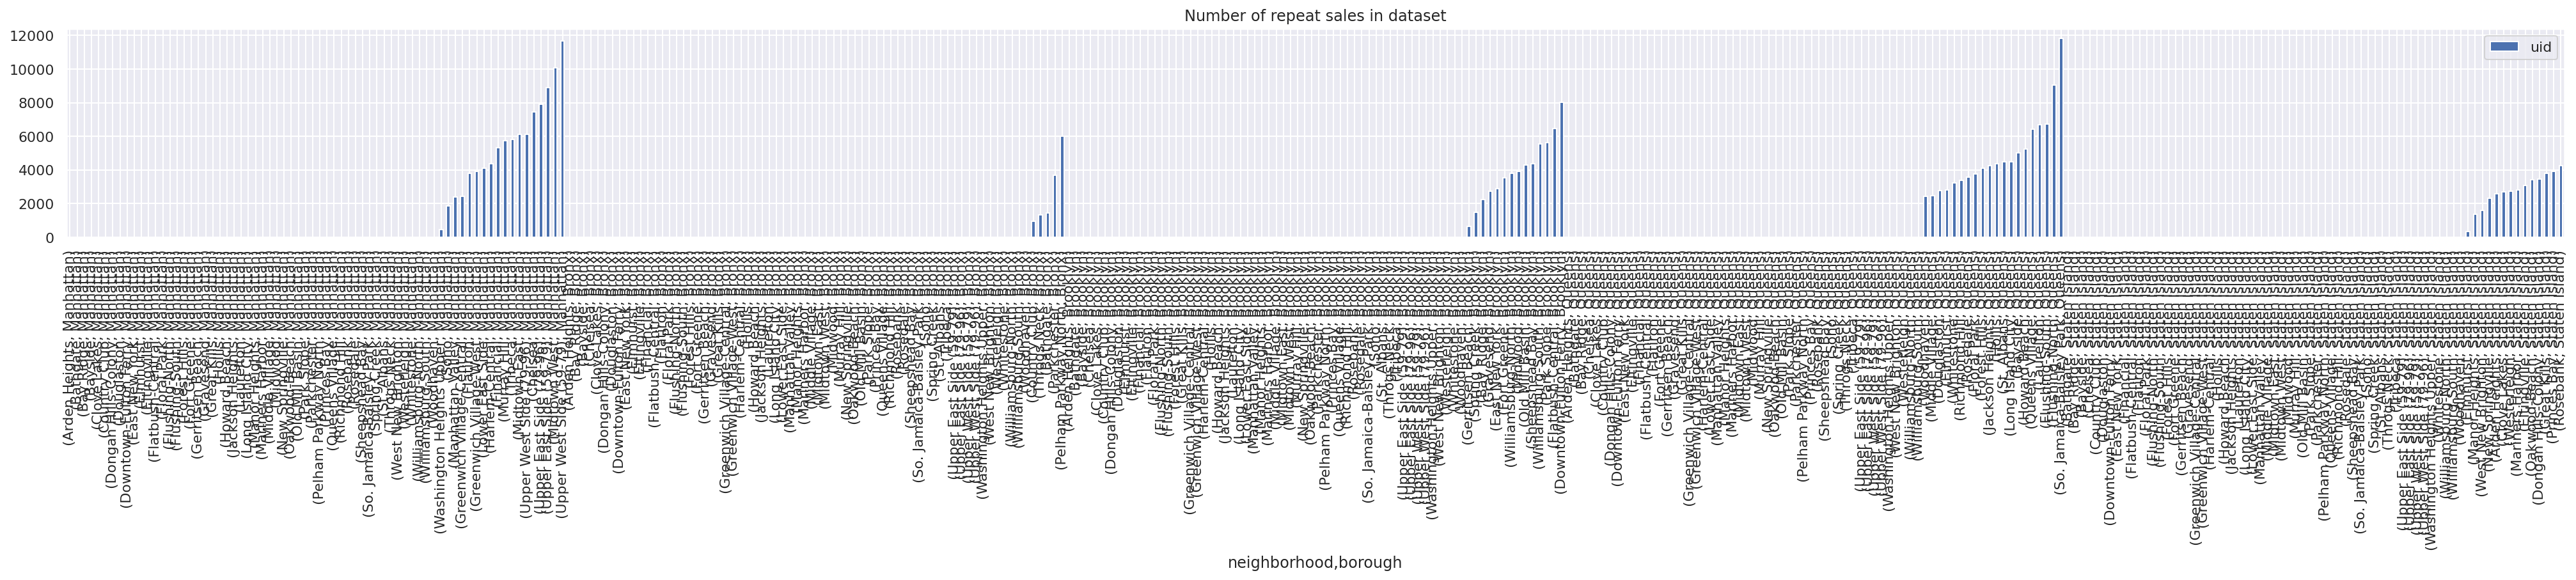

In [68]:
# exclude neighborhoods with very few datapoints
FILTERED_NEIGHBORHOODS=['Manhattan-Unknown',
                        'Brooklyn-Unknown',
                        'Roosevelt Island',
                        'Bush Terminal',
                        'Navy Yard',
                        'Staten Island Unknown',
                        ]

filtered = rpt_sales.neighborhood.isin(FILTERED_NEIGHBORHOODS)
neighborhood_sales = rpt_sales[~filtered].replace({"neighborhood": hood_dict})
neighborhood_sales.groupby(['borough','neighborhood']).count().uid.dropna() \
    .reset_index('borough').sort_values(by=['borough', 'uid']).set_index('borough', append=True) \
    .plot.bar(figsize=(35,3), title="Number of repeat sales in dataset")

Show the number of repeat transactions in each neighborhood for the most recent period.

In [65]:
print(neighborhood_sales[neighborhood_sales.period==mr_period].groupby(by=['borough', 'neighborhood']).count().uid.dropna().reset_index('borough').sort_values(by=['borough', 'uid'],ascending=False).set_index('borough', append=True).to_string())

                                         uid
neighborhood              borough           
Mariners Harbor           Staten Island   14
Princes Bay               Staten Island   11
Clove Lakes               Staten Island   10
New Springville           Staten Island   10
Oakwood-Beach             Staten Island   10
Rosebank                  Staten Island   10
Dongan Hills-Colony       Staten Island    8
Great Kills               Staten Island    8
Eltingville               Staten Island    7
Westerleigh               Staten Island    7
Arden Heights             Staten Island    6
West New Brighton         Staten Island    5
Elmhurst                  Staten Island    4
Manor Heights             Staten Island    3
Bathgate                  Staten Island    0
Bay Ridge                 Staten Island    0
Bayside                   Staten Island    0
Chelsea                   Staten Island    0
Country Club              Staten Island    0
Douglaston                Staten Island    0
Downtown-F

Create index values for every neighborhood, along with rolling averages

Display graph indices for all neighborhoods, in alphabetical order

In [78]:
neighborhood_idx = generateIndexValues(neighborhood_sales,'neighborhood')

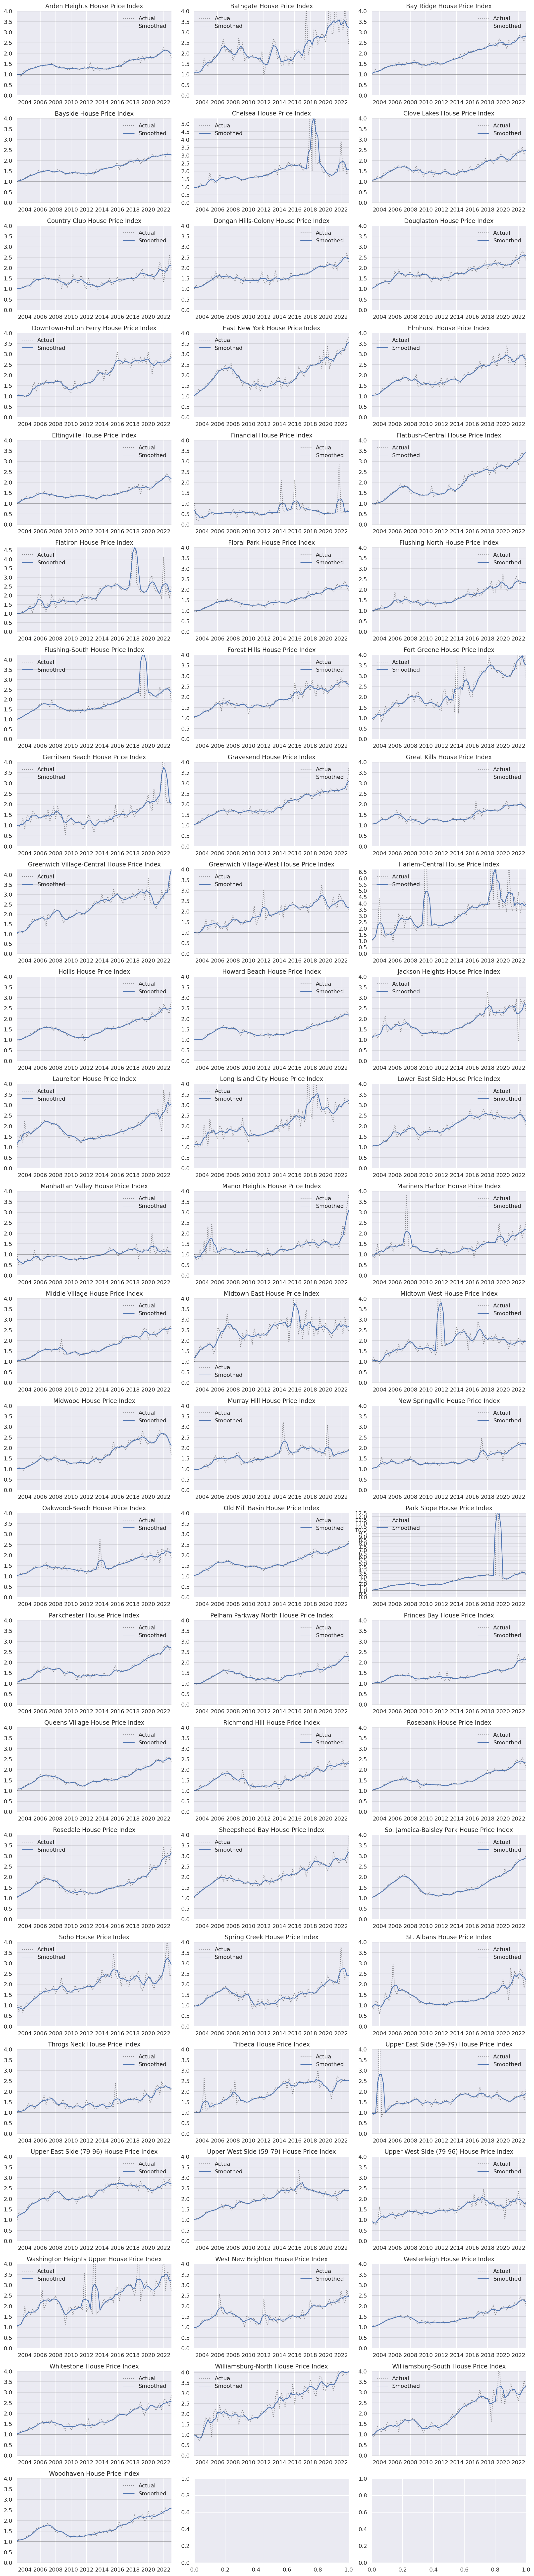

In [79]:
ncols = 3
nrows = int(np.ceil(len(neighborhood_idx.groupby('neighborhood').groups) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3), sharey=False)

for row, (name, idx) in enumerate(neighborhood_idx.groupby('neighborhood')):
    ylim = (0, max(4.0, idx.smoothed.max()))
    plot_idx(idx, axes.flat[row], name, ylim=ylim)

fig.patch.set_alpha(1.0)                                         
fig.tight_layout()

Calculate the year over year price change for each neighborhood, sort values, and plot:

<ipython-input-44-54d12e5df0e4>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=90, fontsize=11)


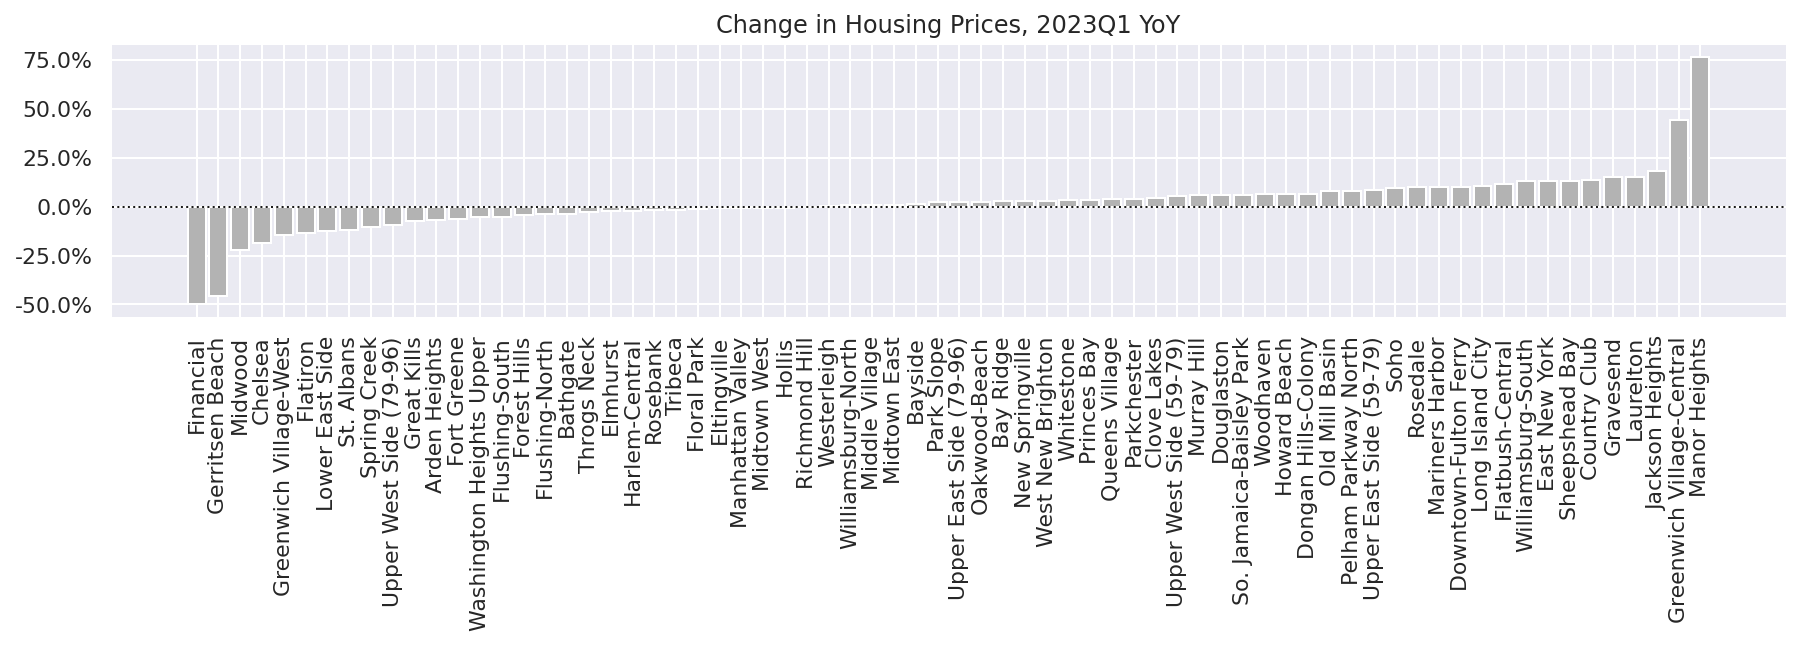

In [80]:
mr = neighborhood_idx.set_index('neighborhood',append=True).smoothed.unstack('neighborhood').pct_change(4).iloc[qtr_offset]
mr.sort_values(inplace=True)
plot_standings(mr, title=f"Change in Housing Prices, {neighborhood_idx.index[qtr_offset]} YoY")

Print the percent change in house values as well for reference:

In [81]:
print(mr.map('{:,.0%}'.format).to_string())

neighborhood
Financial                    -50%
Gerritsen Beach              -46%
Midwood                      -22%
Chelsea                      -19%
Greenwich Village-West       -15%
Flatiron                     -14%
Lower East Side              -13%
St. Albans                   -12%
Spring Creek                 -10%
Upper West Side (79-96)       -9%
Great Kills                   -7%
Arden Heights                 -7%
Fort Greene                   -6%
Washington Heights Upper      -5%
Flushing-South                -5%
Forest Hills                  -4%
Flushing-North                -4%
Bathgate                      -4%
Throgs Neck                   -3%
Elmhurst                      -2%
Harlem-Central                -2%
Rosebank                      -2%
Tribeca                       -2%
Floral Park                   -1%
Eltingville                   -1%
Manhattan Valley              -1%
Midtown West                  -1%
Hollis                        -1%
Richmond Hill                 -0%
W

Show the Quarter over Quarter change:

<ipython-input-44-54d12e5df0e4>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=90, fontsize=11)


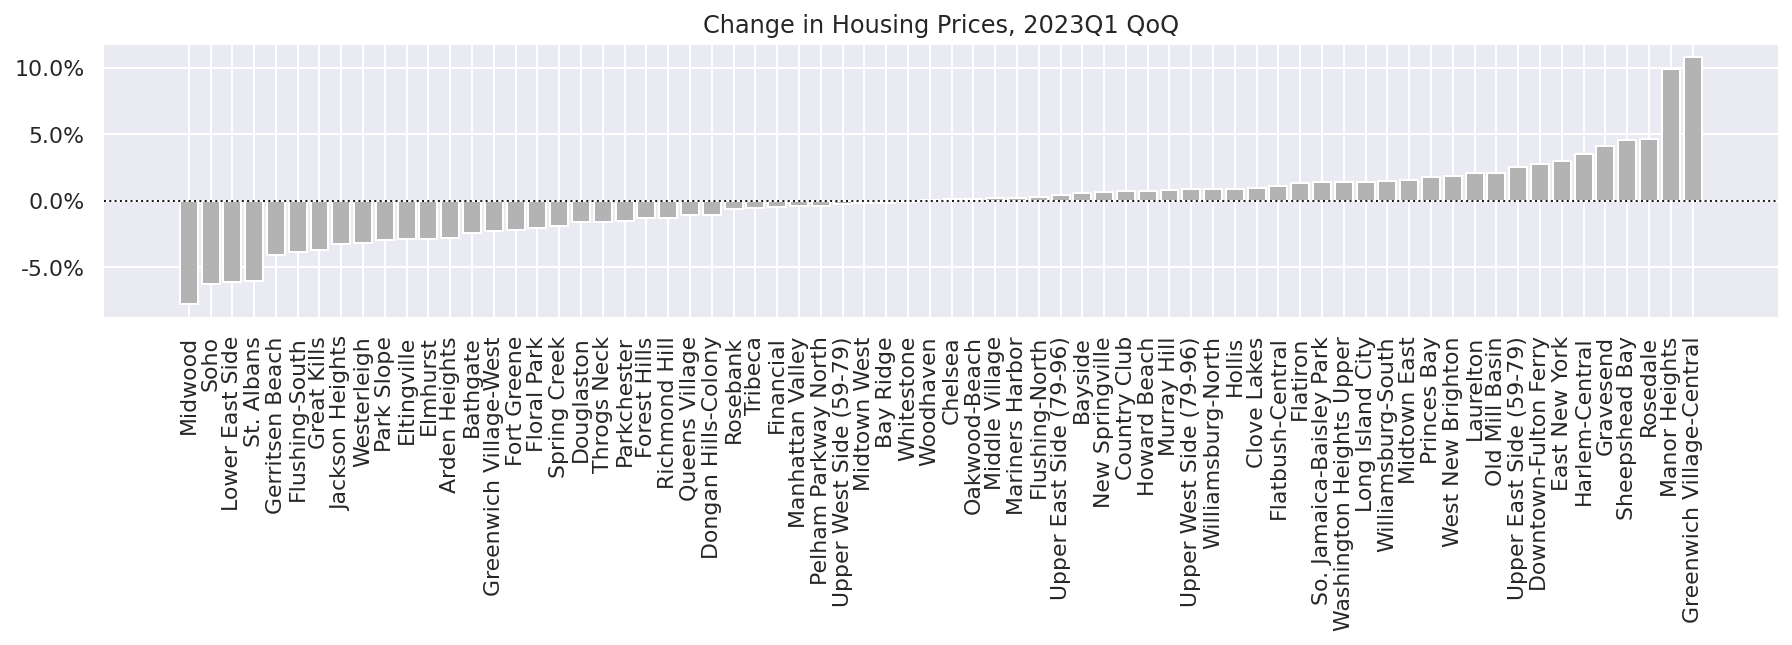

In [82]:
mr = neighborhood_idx.set_index('neighborhood',append=True).smoothed.unstack('neighborhood').pct_change().iloc[qtr_offset]
mr.sort_values(inplace=True)
plot_standings(mr, title=f"Change in Housing Prices, {neighborhood_idx.index[qtr_offset]} QoQ")

In [83]:
print(mr.map('{:,.0%}'.format).to_string())

neighborhood
Midwood                      -8%
Soho                         -6%
Lower East Side              -6%
St. Albans                   -6%
Gerritsen Beach              -4%
Flushing-South               -4%
Great Kills                  -4%
Jackson Heights              -3%
Westerleigh                  -3%
Park Slope                   -3%
Eltingville                  -3%
Elmhurst                     -3%
Arden Heights                -3%
Bathgate                     -2%
Greenwich Village-West       -2%
Fort Greene                  -2%
Floral Park                  -2%
Spring Creek                 -2%
Douglaston                   -2%
Throgs Neck                  -2%
Parkchester                  -2%
Forest Hills                 -1%
Richmond Hill                -1%
Queens Village               -1%
Dongan Hills-Colony          -1%
Rosebank                     -1%
Tribeca                      -1%
Financial                    -0%
Manhattan Valley             -0%
Pelham Parkway North         -